In [2]:
!pip3 install torch torchvision

In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

In [5]:
transform_train = transforms.Compose([
                                transforms.Resize((32,32)),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(10),
                                transforms.RandomAffine(0, shear = 10, scale = (0.8,1.2)),
                                transforms.ColorJitter(brightness = 0.2, contrast=0.2, saturation = 0.2),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5),(0.5,.5,0.5))])

transform = transforms.Compose([
                                transforms.Resize((32,32)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
training_dataset = datasets.CIFAR10(root = "./data", train = True, download = True, transform =transform_train)
validation_dataset = datasets.CIFAR10(root = "./data", train = False, download = True, transform =transform)

validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100, shuffle = False)
training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle = True)

100%|██████████| 170498071/170498071 [00:01<00:00, 96044989.98it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
def image_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5))
  image = image.clip(0, 1)
  return image

In [7]:
classes = ('plane','car','bird','cat', 'deer', 'dog', 'frog','horse','ship','truck')

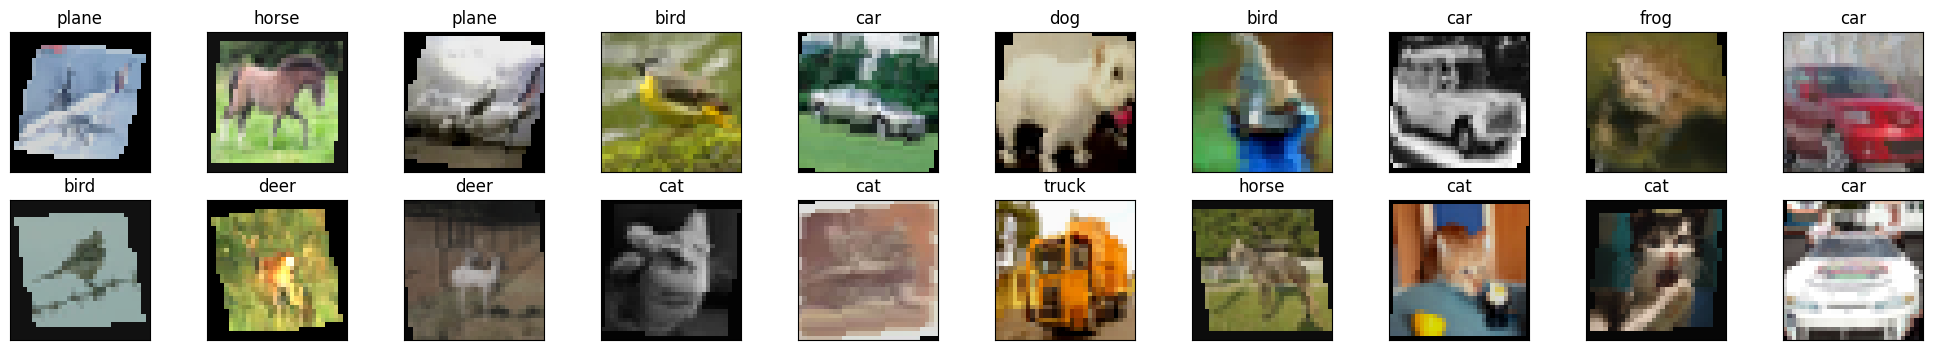

In [8]:
dataIter = iter(training_loader)
images, labels = next(dataIter)
fig = plt.figure(figsize=(25,4))

for idx in np.arange(20):
  ax = fig.add_subplot(2,10, idx+1, xticks = [],yticks = [])
  plt.imshow(image_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

In [9]:
class LeNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 16, 3, 1, padding = 1)
    self.conv2 = nn.Conv2d(16, 32, 3, 1, padding = 1)
    self.conv3 = nn.Conv2d(32, 64, 3, 1, padding = 1)
    self.fc1 = nn.Linear(64*4*4,500)
    self.dropout1 = nn.Dropout(p=0.5)
    self.fc2 = nn.Linear(500,10)
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x,2,2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x,2,2)
    x = F.relu(self.conv3(x))
    x = F.max_pool2d(x,2,2)
    x = x.view(-1,4*4*64)
    x = F.relu(self.fc1(x))
    x = self.dropout1(x)
    x = self.fc2(x)
    return x

In [10]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [12]:
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []



for e in range(epochs):
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0

  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _, preds = torch.max(outputs,1)
    running_corrects += torch.sum(preds == labels.data)

    running_loss += loss.item()
  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs,val_labels)

        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)


      val_epoch_loss = val_running_loss/len(validation_loader)
      val_epoch_accuracy = val_running_corrects.float()/len(validation_loader)
      val_running_corrects_history.append(val_epoch_accuracy.to("cpu"))
      val_running_loss_history.append(val_epoch_loss)




    epoch_loss = running_loss/len(training_loader)
    epoch_accuracy = running_corrects.float()/len(training_loader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_accuracy.to("cpu"))

    print("Epoch: {}".format(e+1))
    print("Training Loss: {:.4f}, acc: {:.4f}".format(epoch_loss,epoch_accuracy.item()))
    print("Validation Loss: {:.4f}, acc: {:.4f}".format(val_epoch_loss,val_epoch_accuracy.item()))


Epoch: 1
Training Loss: 1.6850, acc: 38.0800
Validation Loss: 1.3921, acc: 49.9300
Epoch: 2
Training Loss: 1.3897, acc: 49.4060
Validation Loss: 1.2585, acc: 55.1900
Epoch: 3
Training Loss: 1.2696, acc: 54.3400
Validation Loss: 1.1337, acc: 58.8400
Epoch: 4
Training Loss: 1.1778, acc: 57.8960
Validation Loss: 1.0689, acc: 62.0800
Epoch: 5
Training Loss: 1.1093, acc: 60.2820
Validation Loss: 1.0038, acc: 65.3100
Epoch: 6
Training Loss: 1.0575, acc: 62.4220
Validation Loss: 0.9532, acc: 66.4100
Epoch: 7
Training Loss: 1.0176, acc: 64.1140
Validation Loss: 0.9463, acc: 66.9200
Epoch: 8
Training Loss: 0.9818, acc: 65.3680
Validation Loss: 0.8749, acc: 69.9600
Epoch: 9
Training Loss: 0.9557, acc: 66.3980
Validation Loss: 0.8558, acc: 70.0300
Epoch: 10
Training Loss: 0.9362, acc: 67.0120
Validation Loss: 0.8537, acc: 70.5300
Epoch: 11
Training Loss: 0.9058, acc: 68.2620
Validation Loss: 0.8296, acc: 71.6400
Epoch: 12
Training Loss: 0.8911, acc: 68.8180
Validation Loss: 0.8659, acc: 70.6200
E

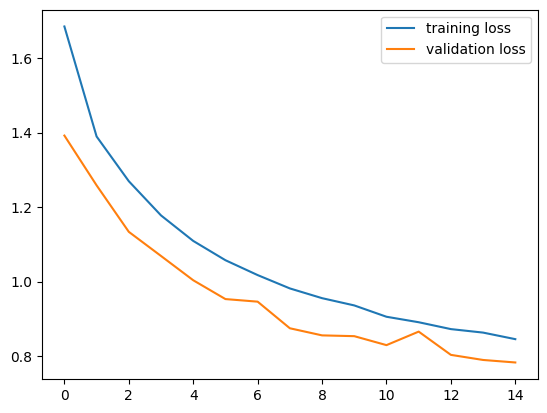

In [13]:
plt.plot(running_loss_history, label = "training loss")
plt.plot(val_running_loss_history,label="validation loss")
plt.legend()

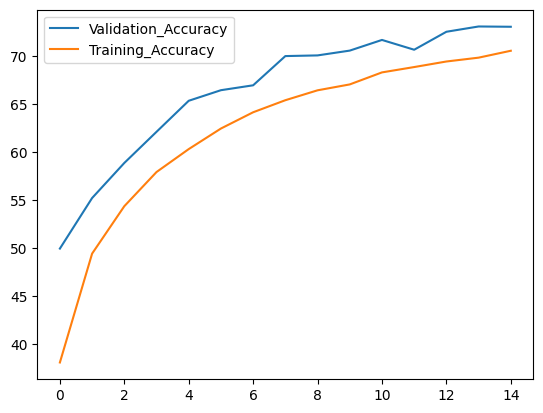

In [14]:
plt.plot(val_running_corrects_history,label = "Validation_Accuracy")
plt.plot(running_corrects_history,label = "Training_Accuracy")
plt.legend()

<Response [200]>


PIL.JpegImagePlugin.JpegImageFile

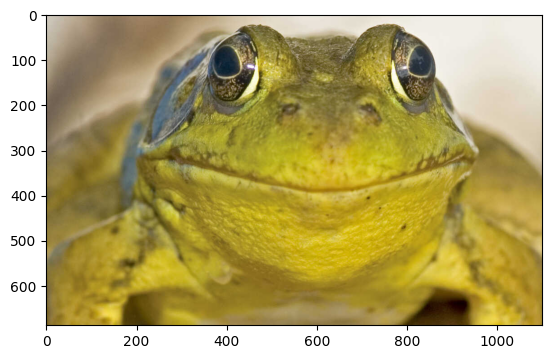

In [15]:
import requests
import PIL
from PIL import Image
url = "https://media.npr.org/assets/img/2013/08/08/istock-3838827-frog-bullfrog_custom-a56f07557e96f6f7c1e76d2ad81735e60b323efe-s1100-c50.jpg"
response = requests.get(url,stream = True)
print(response)
img = Image.open(response.raw)
plt.imshow(img)
type(img)

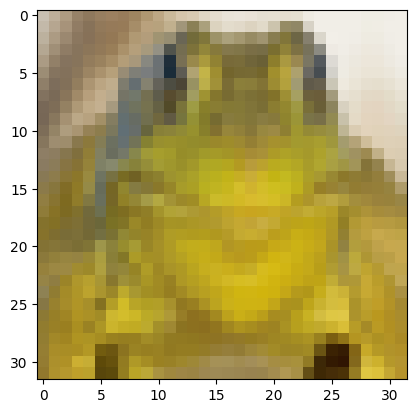

In [16]:
img = transform(img)
plt.imshow(image_convert(img))

In [17]:
image = img.to(device)
output = model(image)
_, pred = torch.max(output,1)
print(classes[pred.item()])

bird


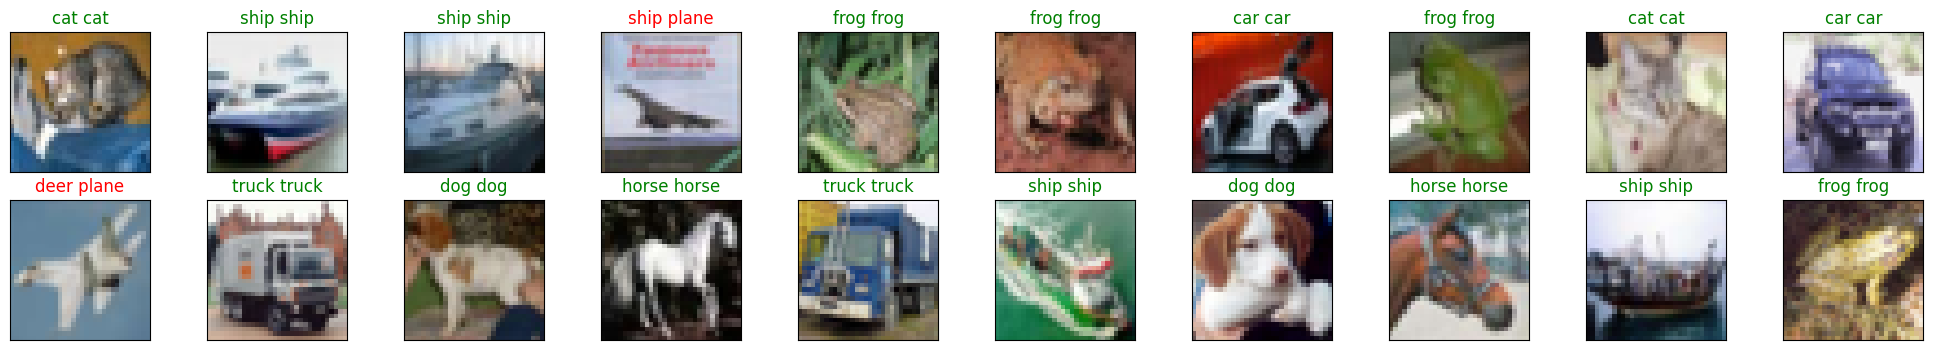

In [18]:
dataIter = iter(validation_loader)
images, labels = next(dataIter)
images_ = images.to(device)
output = model(images_)
_, preds = torch.max(output,1)

fig = plt.figure(figsize=(25,4))

for idx in np.arange(20):
  ax = fig.add_subplot(2,10, idx+1, xticks = [],yticks = [])
  plt.imshow(image_convert(images[idx]))
  ax.set_title("{} {}".format(str(classes[preds[idx].item()]),str(classes[labels[idx].item()])),color=("green" if preds[idx] == labels[idx] else "red"))